In [167]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn import tree
from imblearn.under_sampling import RandomUnderSampler

# Librerías adicionales
import itertools  # Para generar combinaciones de columnas
import matplotlib.patches as mpatches  # Para manejar gráficos

# Importación de módulo personalizado
import payments_manager as pm

# Inicialización del proyecto (si es necesario)
# pm.help()  # Si se necesita ayuda del módulo
# pm.reset()  # Para reiniciar cualquier configuración anterior
# pm.init()  # Si es necesario inicializar el módulo con opciones (por ejemplo, debug=True)

# Cargar y preparar el DataFrame df_jo
df_jo = pm.df('df_jo')  # Cargar el DataFrame desde 'payments_manager'
df_jo.info()  # Ver información básica sobre el DataFrame

# Ordenar el DataFrame df_jo por la columna 'id_cr' y resetear índices
df_jo = df_jo.sort_values(by=["id_cr"]).reset_index(drop=True)

# Crear una copia del DataFrame para su posterior uso
df_jo_cp = df_jo.copy()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

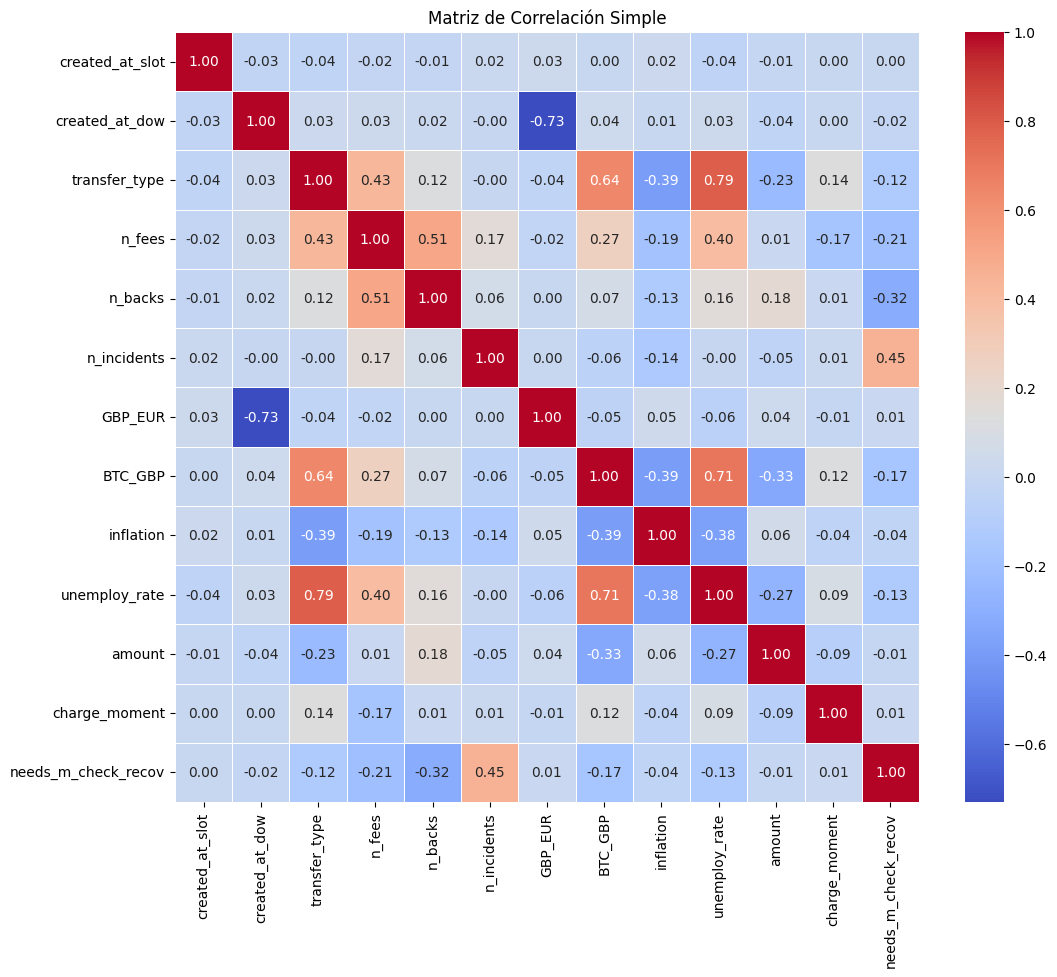

In [168]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment','needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type'
df_simpl = df_simpl.copy()
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})
df_simpl['charge_moment'] = df_simpl['charge_moment'].map({'before': 0, 'after': 1})

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [ ]:
# df nuevos clientes
new_users_df = df_simpl[(df_simpl['n_fees'] == 0) & (df_simpl['n_backs'] == 0) & (df_simpl['n_incidents'] == 0)]
print(new_users_df.info())

# df clientes repetitivos
rep_users_df = df_simpl[(df_simpl['n_fees'] > 0) | (df_simpl['n_backs'] > 0) | (df_simpl['n_incidents'] > 0)]
print(rep_users_df.info())
rep_users_df




<class 'pandas.core.frame.DataFrame'>
Index: 1910 entries, 1 to 32086
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   created_at_slot      1910 non-null   int32  
 1   created_at_dow       1910 non-null   int32  
 2   transfer_type        1910 non-null   int64  
 3   n_fees               1910 non-null   int64  
 4   n_backs              1910 non-null   int64  
 5   n_incidents          1910 non-null   int64  
 6   GBP_EUR              1910 non-null   float64
 7   BTC_GBP              1910 non-null   float64
 8   inflation            1910 non-null   float64
 9   unemploy_rate        1910 non-null   float64
 10  amount               1910 non-null   float64
 11  charge_moment        0 non-null      float64
 12  needs_m_check_recov  1910 non-null   int64  
dtypes: float64(6), int32(2), int64(5)
memory usage: 194.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 30159 entries, 0 to 32091
Data colu

,created_at_slot,created_at_dow,transfer_type,n_fees,n_backs,n_incidents,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment,needs_m_check_recov
0,13,1,0,0,-1,1,1.16935,6347.577148,1.3,3.9,1.0,NaN,1
2,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
3,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
4,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
5,19,1,0,0,0,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,23,6,1,2,1,1,0.00000,10627.522461,0.7,5.3,50.0,1.0,0
32088,23,6,1,3,2,0,0.00000,10627.522461,0.7,5.3,100.0,1.0,0
32089,23,6,1,2,1,8,0.00000,10627.522461,0.7,5.3,50.0,NaN,1
32090,23,6,1,1,0,0,0.00000,10627.522461,0.7,5.3,60.0,1.0,0


In [189]:
# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts = df_simpl['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual = (value_counts[1] / total) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check: {needs_manual:.2f} %')


Porcentaje de operaciones con needs_m_check: 52.31 %


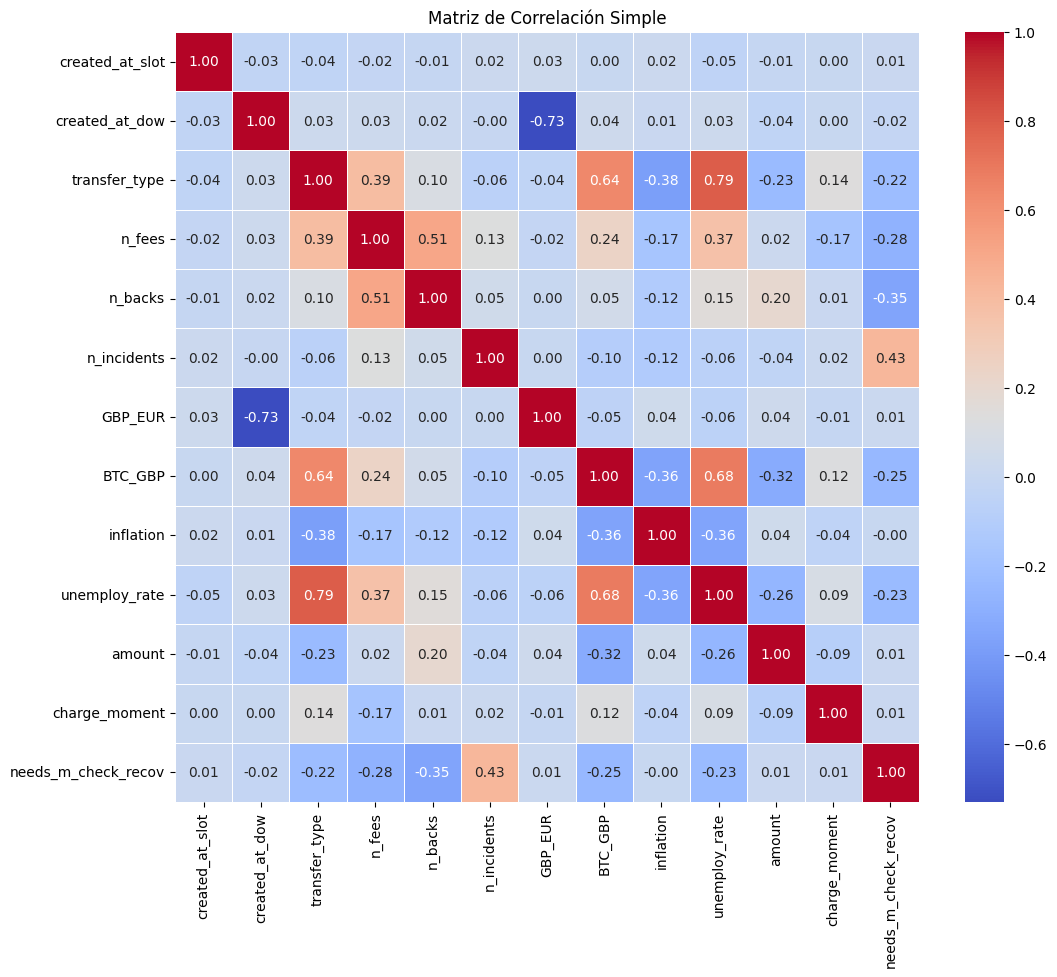

,created_at_slot,created_at_dow,transfer_type,n_fees,n_backs,n_incidents,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment,needs_m_check_recov
0,13,1,0,0,-1,1,1.16935,6347.577148,1.3,3.9,1.0,NaN,1
2,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
3,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
4,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
5,19,1,0,0,0,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,23,6,1,2,1,1,0.00000,10627.522461,0.7,5.3,50.0,1.0,0
32088,23,6,1,3,2,0,0.00000,10627.522461,0.7,5.3,100.0,1.0,0
32089,23,6,1,2,1,8,0.00000,10627.522461,0.7,5.3,50.0,NaN,1
32090,23,6,1,1,0,0,0.00000,10627.522461,0.7,5.3,60.0,1.0,0


In [194]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas_2 = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment','needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl2 = rep_users_df[columnas_deseadas_2]

# Calcular la matriz de correlación
m_corr_simpl_2 = df_simpl2.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl_2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()
df_simpl2

In [196]:
# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts = df_simpl2['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual = (value_counts[1] / total) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check: {needs_manual:.2f} %')

Porcentaje de operaciones con needs_m_check: 55.66 %


In [180]:
# Balanceo de cargas

columns = df_simpl2.columns
X_b = df_simpl2.drop('needs_m_check_recov', axis=1)
y_b = df_simpl2['needs_m_check_recov']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X_b, y_b)

print(pd.Series(y_under).value_counts())

needs_m_check_recov
0    13371
1    13371
Name: count, dtype: int64


In [181]:
columns_X = np.delete(columns, 12)
columns_y = columns[-1]
columns_X

Index(['created_at_slot', 'created_at_dow', 'transfer_type', 'n_fees',
       'n_backs', 'n_incidents', 'GBP_EUR', 'BTC_GBP', 'inflation',
       'unemploy_rate', 'amount', 'charge_moment'],
      dtype='object')

In [182]:
X_b_df = pd.DataFrame(X_under, columns=columns_X)
y_b_df = pd.DataFrame(y_under, columns=[columns_y])

new_b_df = pd.concat([X_b_df, y_b_df], axis=1)


<Axes: title={'center': 'Distribución después de submuestreo'}, xlabel='needs_m_check_recov'>

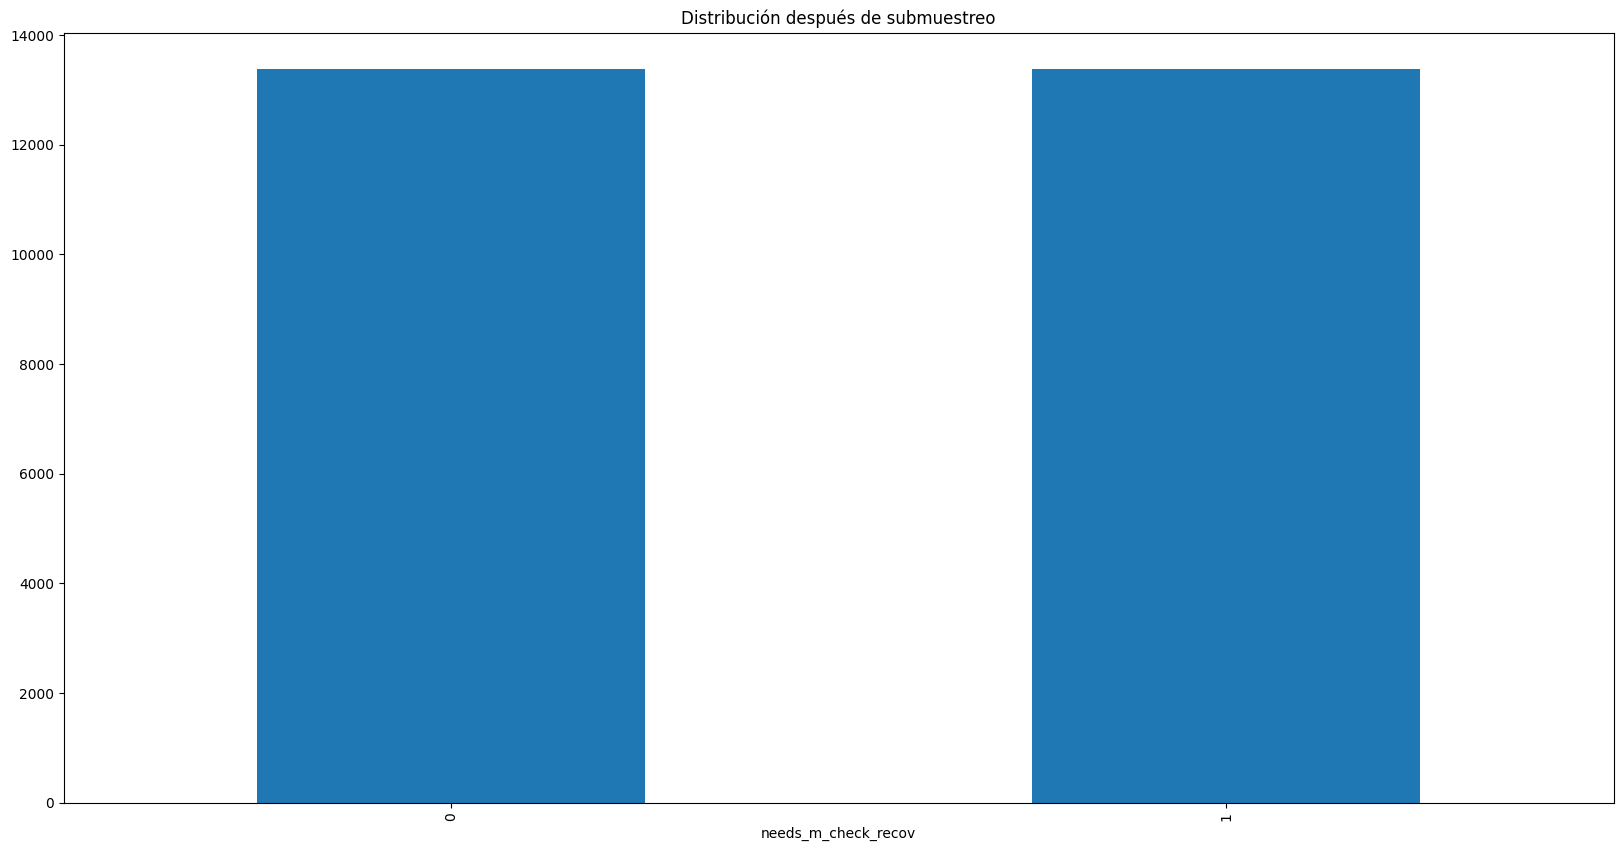

In [183]:
plt.rcParams['figure.figsize']=[20,10]
new_b_df.needs_m_check_recov.value_counts().plot(kind='bar', title='Distribución después de submuestreo')

In [205]:
# Crea la matriz de características y la var objetivo
X = df_simpl2.drop(columns=[
   'needs_m_check_recov',  
#    'created_at_slot',      
    'created_at_dow',       
    'transfer_type',
#   'n_fees',
#    'n_backs',
#    'n_incidents',
 #   'GBP_EUR',
 #   'BTC_GBP',
    'inflation',      
    'unemploy_rate',
  'amount',

])
y = df_simpl2['needs_m_check_recov']  # La columna de la variable objetivo

print(X.shape)
print(y.shape)
X.head(50)

(30159, 7)
(30159,)


,created_at_slot,n_fees,n_backs,n_incidents,GBP_EUR,BTC_GBP,charge_moment
0,13,0,-1,1,1.16935,6347.577148,NaN
2,19,0,-1,1,1.18800,5543.707520,NaN
3,19,0,-1,1,1.18800,5543.707520,NaN
4,19,0,-1,1,1.18800,5543.707520,NaN
5,19,0,0,1,1.18800,5543.707520,NaN
6,19,0,-1,1,1.18800,5543.707520,NaN
8,19,0,-1,1,1.18800,5543.707520,NaN
11,19,0,-1,1,1.18800,5543.707520,NaN
12,19,0,0,1,1.18800,5543.707520,NaN
14,19,0,-1,1,1.18800,5543.707520,NaN


In [206]:
# MODELO DE ÁRBOL DE DECISIÓN

# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Árbol de Decisión
DT = tree.DecisionTreeClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
DT.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = DT.predict(test_X)




Precisión del modelo: 0.8864

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      2647
           1       0.90      0.89      0.90      3385

    accuracy                           0.89      6032
   macro avg       0.88      0.89      0.88      6032
weighted avg       0.89      0.89      0.89      6032


Importancia de las características (ordenadas por magnitud):
n_incidents: 0.6711
n_backs: 0.0817
BTC_GBP: 0.0768
created_at_slot: 0.0737
GBP_EUR: 0.0478
n_fees: 0.0305
charge_moment: 0.0184


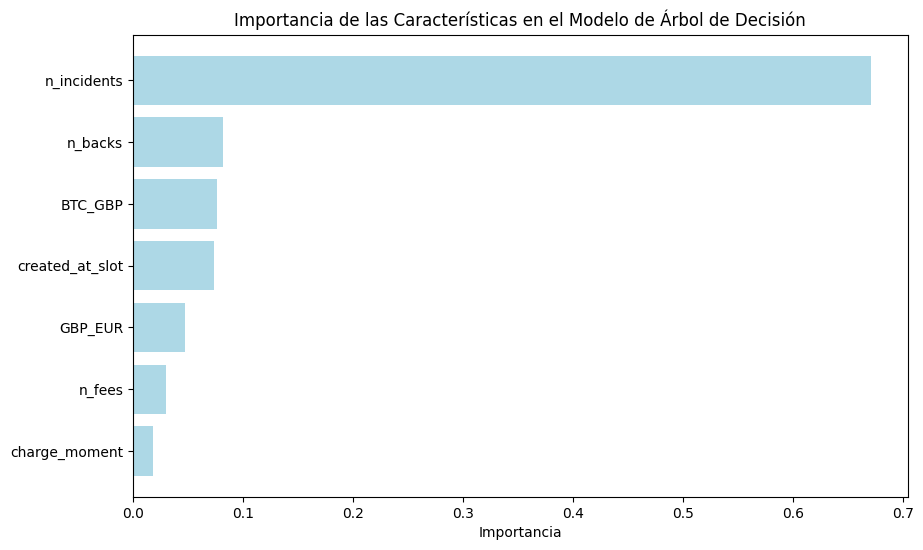

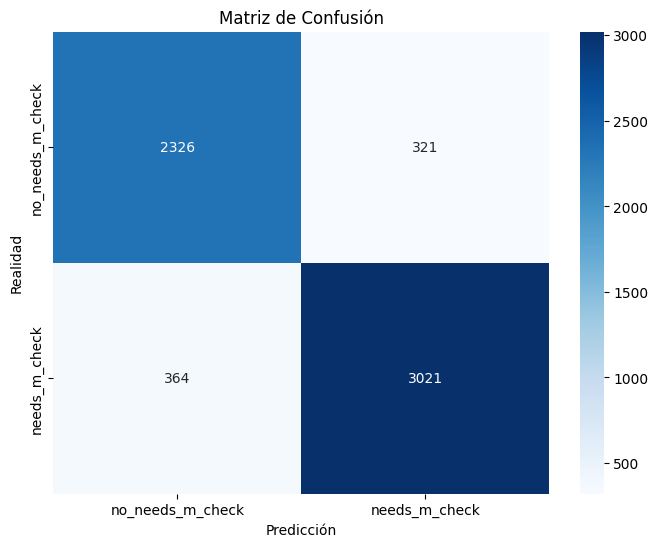

In [207]:
# Evaluación del rendimiento del modelo

# 1. Precisión del modelo
accuracy = DT.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = DT.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]
importances = [f[1] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()



In [203]:
# MODELO RANDOM FOREST
X_rf = df_simpl2.drop(columns=[
    'needs_m_check_recov',  
#    'created_at_slot',      
#    'created_at_dow',       
#    'transfer_type',
#   'n_fees',    
#   'n_backs',
#    'n_incidents',
#    'GBP_EUR',
#    'BTC_GBP',
#    'inflation',      
#    'unemploy_rate',
#    'amount',

])
Y_rf = df_simpl2['needs_m_check_recov'] 


In [204]:
# Se escoge el modelo para evaluar el subset de atributos
RF = RandomForestClassifier()
# Se escoge el número de los atributos a seleccionar
rfe = RFE(RF)
rfe = rfe.fit(X_rf, Y_rf)
print('Mejores características: ',X_rf.columns[rfe.support_])


Mejores características:  Index(['created_at_slot', 'n_fees', 'n_backs', 'n_incidents', 'GBP_EUR',
       'BTC_GBP'],
      dtype='object')


In [208]:
# Crear el clasificador RandomForest
clf_rf_4 = RandomForestClassifier()

# Inicializar RFECV con validación cruzada (3-fold)
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=3, scoring='accuracy')  # 3-fold cross-validation

# Ajustar el modelo
rfecv = rfecv.fit(X_rf, Y_rf)

# Mostrar el número óptimo de características seleccionadas
print('Número óptimo de características:', rfecv.n_features_)

# Mostrar las mejores características seleccionadas
print('Mejores características:', X_rf.columns[rfecv.support_])

Número óptimo de características: 1
Mejores características: Index(['n_incidents'], dtype='object')


In [209]:
# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo RandomForest
RF = RandomForestClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
RF.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = RF.predict(test_X)




Precisión del modelo: 0.9085

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      2647
           1       0.91      0.93      0.92      3385

    accuracy                           0.91      6032
   macro avg       0.91      0.91      0.91      6032
weighted avg       0.91      0.91      0.91      6032


Importancia de las características (ordenadas por magnitud):
n_incidents: 0.5026
n_backs: 0.1503
BTC_GBP: 0.0908
n_fees: 0.0829
created_at_slot: 0.0700
GBP_EUR: 0.0542
charge_moment: 0.0493


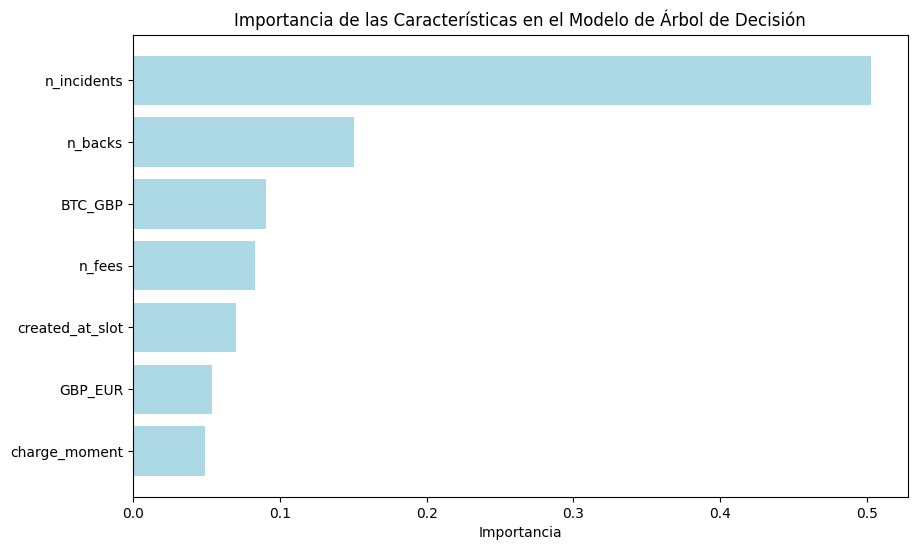

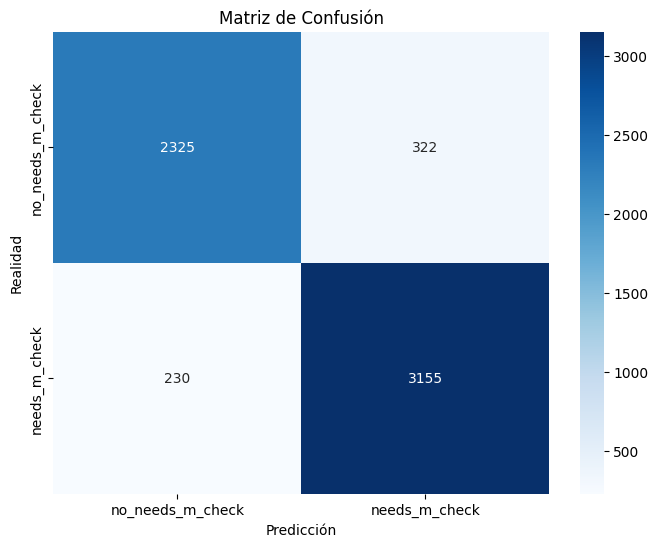

In [210]:
# Evaluación del rendimiento del modelo

# 1. Precisión del modelo
accuracy = RF.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = RF.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]
importances = [f[1] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()


In [ ]:
new_b_df

,created_at_slot,created_at_dow,transfer_type,n_fees,n_backs,n_incidents,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment,needs_m_check_recov
1688,23,2,0,2,2,2,1.12963,7573.682129,0.5,4.2,100.0,0.0,0
1689,23,2,0,1,2,2,1.12963,7573.682129,0.5,4.2,100.0,0.0,0
1774,16,4,0,1,1,6,1.13180,7706.900391,0.5,4.2,10.0,0.0,0
1811,17,4,0,1,1,3,1.13180,7706.900391,0.5,4.2,100.0,0.0,0
1976,22,1,0,1,1,3,1.11761,7938.505859,0.5,4.2,100.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25128,7,1,1,2,1,3,1.10550,8833.477539,0.7,5.2,50.0,NaN,1
12030,8,4,1,1,1,2,1.10600,8890.011719,0.2,5.0,100.0,1.0,1
24773,15,6,1,2,1,1,0.00000,8736.459961,0.7,5.2,100.0,1.0,1
11457,20,1,0,2,3,24,1.11193,8563.139648,0.2,5.0,100.0,1.0,1


In [227]:
df_simpl2

,created_at_slot,created_at_dow,transfer_type,n_fees,n_backs,n_incidents,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment,needs_m_check_recov
0,13,1,0,0,-1,1,1.16935,6347.577148,1.3,3.9,1.0,NaN,1
2,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
3,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
4,19,1,0,0,-1,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
5,19,1,0,0,0,1,1.18800,5543.707520,1.3,4.0,100.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,23,6,1,2,1,1,0.00000,10627.522461,0.7,5.3,50.0,1.0,0
32088,23,6,1,3,2,0,0.00000,10627.522461,0.7,5.3,100.0,1.0,0
32089,23,6,1,2,1,8,0.00000,10627.522461,0.7,5.3,50.0,NaN,1
32090,23,6,1,1,0,0,0.00000,10627.522461,0.7,5.3,60.0,1.0,0


In [244]:
# NORMALIZACION Y ESCALADO

# Eliminar las columnas no necesarias del DataFrame
X_s = df_simpl2.drop(columns=[
     'needs_m_check_recov',  
    #  'created_at_slot',      
      'created_at_dow',       
      'transfer_type',
      # 'n_fees',
      # 'n_backs',
      # 'n_incidents',
      # 'GBP_EUR',
      # 'BTC_GBP',
      'inflation',      
      'unemploy_rate',
      'amount',
      'charge_moment'
])

# Definir la variable objetivo
Y_s = df_simpl2['needs_m_check_recov']

# Lista de columnas a normalizar
col_names = [
    #'created_at_slot',      
    'created_at_dow',       
    #'transfer_type',
     'n_fees',
     'n_backs',
     'n_incidents',
     'GBP_EUR',
     'BTC_GBP',
#     'inflation',      
#     'unemploy_rate',
#     'amount',
#     'charge_moment'
 ]

# Aplicar StandardScaler para la normalización
s_scaler = StandardScaler()
X_s = s_scaler.fit_transform(X_s)

# Convertir los datos escalados de nuevo a un DataFrame con los nombres de columna correctos
X_s = pd.DataFrame(X_s, columns=col_names)

# Imprimir las formas de los datos
print(X_s.shape)
print(Y_s.shape)
X_s



(30159, 6)
(30159,)


,created_at_dow,n_fees,n_backs,n_incidents,GBP_EUR,BTC_GBP
0,0.069146,-0.918359,-1.040366,-0.366321,0.644999,-2.086338
1,1.204463,-0.918359,-1.040366,-0.366321,0.686882,-2.886519
2,1.204463,-0.918359,-1.040366,-0.366321,0.686882,-2.886519
3,1.204463,-0.918359,-1.040366,-0.366321,0.686882,-2.886519
4,1.204463,-0.918359,-0.341995,-0.366321,0.686882,-2.886519
...,...,...,...,...,...,...
30154,1.961341,0.845880,0.356375,-0.366321,-1.981103,2.173963
30155,1.961341,1.727999,1.054746,-0.729607,-1.981103,2.173963
30156,1.961341,0.845880,0.356375,2.176679,-1.981103,2.173963
30157,1.961341,-0.036239,-0.341995,-0.729607,-1.981103,2.173963


In [230]:
# Se escoge el modelo para evaluar el subset de atributos
RF = RandomForestClassifier()
# Se escoge el número de los atributos a seleccionar
rfe = RFE(RF)
rfe = rfe.fit(X_s, Y_s)
print('Mejores características: ',X_s.columns[rfe.support_])

Mejores características:  Index(['created_at_slot', 'n_fees', 'n_backs', 'n_incidents', 'GBP_EUR',
       'BTC_GBP'],
      dtype='object')


In [233]:
# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X_s, Y_s, test_size=0.2, random_state=42)

# Crear el modelo RandomForest
RF = RandomForestClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
RF.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = RF.predict(test_X)


Precisión del modelo: 0.8909

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87      2647
           1       0.89      0.93      0.90      3385

    accuracy                           0.89      6032
   macro avg       0.89      0.89      0.89      6032
weighted avg       0.89      0.89      0.89      6032


Importancia de las características (ordenadas por magnitud):
n_incidents: 0.5417
n_backs: 0.1514
BTC_GBP: 0.0907
created_at_dow: 0.0838
n_fees: 0.0748
GBP_EUR: 0.0576


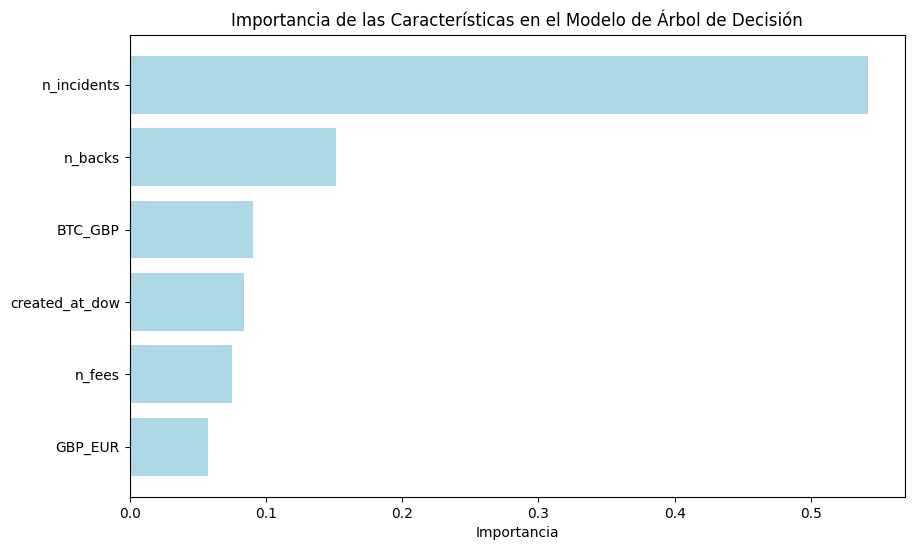

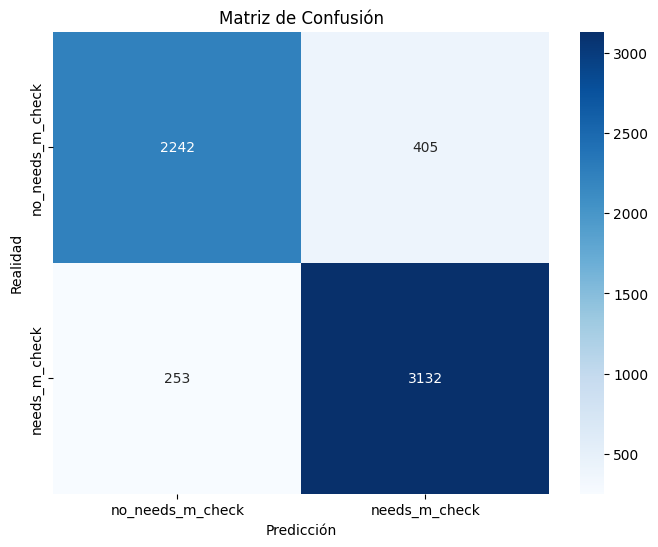

In [ ]:
# Evaluación del rendimiento del modelo

# 1. Precisión del modelo
accuracy = RF.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X_s.columns

# Obtener las importancias de las características del modelo
feature_importances = RF.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]
importances = [f[1] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()

In [243]:
# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X_s, Y_s, test_size=0.2, random_state=42)

# Crear el modelo RandomForest
clf = LogisticRegression(solver="liblinear")

# Entrenar el modelo con el conjunto de datos de entrenamiento
RF.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = RF.predict(test_X)

# Entrena el clasificador
clf.fit(train_X, train_y)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(test_X)

#print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(test_X)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_incidents: 2.9072
n_backs: -1.0650
n_fees: -0.7978
BTC_GBP: -0.2725
created_at_dow: -0.0288
GBP_EUR: -0.0002


In [238]:
# Generamos Df para comparar realidad vs predicción

# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_2 = test_X.reset_index().copy()
X_2["needs_m_check_recov"] = test_y.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_2["prediccion"] = predicciones
X_2 = pd.concat([X_2, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_2[["needs_m_check_recov", "prediccion", 0, 1]].head(10)

,needs_m_check_recov,prediccion,0,1
0,1,1,1.034947e-01,0.896505
1,0,0,7.116512e-01,0.288349
2,0,0,9.312836e-01,0.068716
3,1,1,8.341433e-02,0.916586
4,1,1,6.829715e-02,0.931703
5,0,0,9.515069e-01,0.048493
6,0,1,4.661840e-08,1.000000
7,1,1,8.307705e-03,0.991692
8,1,1,3.831191e-04,0.999617
9,0,0,8.048588e-01,0.195141


Accuracy: 0.8720159151193634
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      2647
           1       0.90      0.87      0.88      3385

    accuracy                           0.87      6032
   macro avg       0.87      0.87      0.87      6032
weighted avg       0.87      0.87      0.87      6032



Text(70.5815972222222, 0.5, 'Realidad')

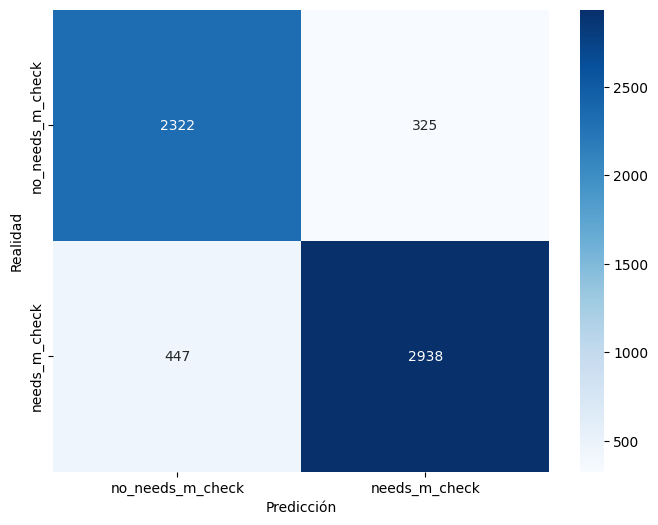

In [ ]:
# Evaluate model performance
print("Accuracy:", clf.score(test_X, (test_y)))  # Accuracy score
print("Classification Report:\n", classification_report(test_y, predicciones))  # Classification report


# Genera la matriz de confusión
matriz_confusion = confusion_matrix(test_y, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")